**Load Data**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from zipfile import ZipFile

with ZipFile("c4_imdb-8k.zip") as zip:
    print("Extracting all the files now...")
    zip.extractall()
    print("Done!")

Extracting all the files now...
Done!


In [4]:
from sklearn.datasets import load_files

# Path to datafolder
PATH_DATA = "c4_imdb-8k"

# load training data
train_data = load_files(
    os.path.join(PATH_DATA, "train"), encoding="ISO-8859-1", categories=["pos", "neg"]
)

# Load test data
test_data = load_files(
    os.path.join(PATH_DATA, "test"), encoding="ISO-8859-1", categories=["pos", "neg"]
)

train_data and test_data are dictionary-like objects with a few interesting attributes:

* the attribute data returns a list of all text samples
* the attribute target returns the labels (as integers)
* the attribute target_names returns the names of the target classes.

In [5]:
#  Training data
print(
    "Training data : Samples: {} - Labels: {} ".format(
        len(train_data.data), len(train_data.target)
    )
)

# Test data
print(
    "Test data     : Samples: {} - Labels: {} ".format(
        len(test_data.data), len(test_data.target)
    )
)

Training data : Samples: 8000 - Labels: 8000 
Test data     : Samples: 8000 - Labels: 8000 


In [6]:
# check target names 
train_data.target_names

['neg', 'pos']

For negative reviews, the target value is 0; for positive reviews, it is 1.

In [7]:
# Print labels of first 3 samples
train_data.target[0:3]  # [neg, neg, pos]

array([0, 0, 1])

In [8]:
# print a review 
train_data.data[1]

'Whatever possessed Guy Ritchie to remake Wertmuller\'s film is incomprehensible.<br /><br />This new film is a mess. There was one other person in the audience when I saw it, and she left about an hour into it. (I hope she demanded a refund.) The only reason I stayed through to the end was because I\'ve never walked out of a movie.<br /><br />But I sat through this piece of junk thoroughly flabbergasted that Madonna and Ritchie could actually think they made a good film. The dialogue is laughable, the acting is atrocious and the only nice thing in this film is the scenery. Ritchie took Lina\'s movie and turned it into another "Blue Lagoon."<br /><br />This is a film that you wouldn\'t even waste time watching late night on Cinemax. Time is too precious to be wasted on crap like this.'

In [9]:
# Load data in a dataframe
import pandas as pd

# Training data
df = pd.DataFrame({"text": train_data.data, "label": train_data.target})

# Test data
df_test = pd.DataFrame({"text": test_data.data, "label": test_data.target})

print("Training data: ", df.shape)
print("Test  data:    ", df_test.shape)

Training data:  (8000, 2)
Test  data:     (8000, 2)


Check for duplicates.

In [10]:
print("Nbr of duplicates in training data: {}".format(df.duplicated().sum()))
print("Nbr of duplicates in test data:  {}".format(df_test.duplicated().sum()))

Nbr of duplicates in training data: 14
Nbr of duplicates in test data:  38


In [11]:
# Drop duplicates from training/test data
df.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("Training data: ", df.shape)
print("Test  data:    ", df_test.shape)

Training data:  (7986, 2)
Test  data:     (7962, 2)


In [12]:
# print a few samples
df.sample(5)

,text,label
889,This is a movie that relies solely on the some...,0
261,My friend's mom used to work at a video store ...,0
802,"Looking at some of the negative posts, you rea...",1
671,<br /><br />I saw this on the Sci-Fi channel. ...,0
6419,A very early Oliver Stone (associate-)produced...,1


In [13]:
df_test.sample(5)

,text,label
3717,This demented left-wing wipe-out trivializes D...,0
3440,My father has worked with top secret informati...,1
7297,Let's face it.<br /><br />This movie is incred...,1
2652,There was a video out in America called 'Carto...,1
127,This is really good. Original ideas in the fil...,1


**Preliminary EDA**

In [14]:
# Number of samples per class in training data
df["label"].value_counts()

1    3995
0    3991
Name: label, dtype: int64

In [15]:
# Number of samples per class in test data
df_test["label"].value_counts()

0    3987
1    3975
Name: label, dtype: int64

We have approximately the same number of positive and negative reviews in the training and the test data. Therefore, we can assume that our dataset is balanced.

*Text Preprocessing*

Below is a list of “issues” that we think we should address in this particular dataset.

* Remove numbers and HTML code for line breaks
* Convert text to lowercase.
* Remove stop words.
* Remove punctuation.
* Apply stemming.

In [18]:
# remove numbers and HTML breaks as for this task of finding neg/pos not relevant
sample = "I don't like the director's suit. But I LOVED his movie! 10/10 <br /><br />"

print("Text sample: \n{}\n".format(sample))

Text sample: 
I don't like the director's suit. But I LOVED his movie! 10/10 <br /><br />



In [19]:
import re 

# remove html code
clean_sample = re.sub(r"<br />", "", sample)

print("Remove html code for line breaks: \n{}\n".format(clean_sample))

Remove html code for line breaks: 
I don't like the director's suit. But I LOVED his movie! 10/10 



In [20]:
# Remove numbers
clean_sample = re.sub(r"\d+", "", clean_sample)

print("Remove numbers from sample: \n{}\n".format(clean_sample))

Remove numbers from sample: 
I don't like the director's suit. But I LOVED his movie! / 



*Case folding*

Number of unique words in a dataset usually called vocabulary. Reducing this benefit of reducing computational resource required to train ML model.

In [21]:
# Case folding
clean_sample = clean_sample.lower()

print("Convert to lowercase: \n{}\n".format(clean_sample))

Convert to lowercase: 
i don't like the director's suit. but i loved his movie! / 



*Tokenization*

Process of splitting text into smaller segments called tokens.

In [22]:
print(clean_sample.split())

['i', "don't", 'like', 'the', "director's", 'suit.', 'but', 'i', 'loved', 'his', 'movie!', '/']


However, this tokenizer is a bit “naive”. For example:

* It didn’t separate punctuation from the adjacent words (e.g. “suit.”, “movie!”).
* It didn’t separate the token “‘s” from the word “director”.
* It didn’t expand the contraction “don’t” to its constituent words “do” and “n’t”.

*TreebankWordTozenizer* more sophisticated.

TreebankWordTokenizer incorporates common rules for English grammar and offers a few nice options. For example:

* It separates most punctuation characters from adjacent words.
* It splits standard contractions, e.g. don’t -> do   n’t and they’ll -> they   ‘ll

In [23]:
# Import tokenizer
from nltk.tokenize import TreebankWordTokenizer

# Create an instance of the TreebankWordTokenizer object
tokenizer = TreebankWordTokenizer()

print("Before tokenization: \n{}\n".format(clean_sample))
print("After tokenization: \n{}\n".format(tokenizer.tokenize(clean_sample)))

Before tokenization: 
i don't like the director's suit. but i loved his movie! / 

After tokenization: 
['i', 'do', "n't", 'like', 'the', 'director', "'s", 'suit.', 'but', 'i', 'loved', 'his', 'movie', '!', '/']



TreebankWordTokenizer assumes that the text has already been segmented into sentences (our text sample has two sentences). For this reason, we need to first split the text into sentences using the nltk.tokenize.sent_tokenize() method and then tokenize each sentence with the TreebankWordTokenizer.

In [24]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt", quiet=True)


def review_tokenizer(text):
    """
    Input: a sentence, or sentences
    Ouput: list of tokens

    """
    # Create empty list
    words = []

    # Split into sentences
    sentences = sent_tokenize(text)

    for sent in sentences:
        words.extend(tokenizer.tokenize(sent))
    return words


print("Before tokenization: \n{}\n".format(clean_sample))
print("After tokenization: \n{}\n".format(review_tokenizer(clean_sample)))

Before tokenization: 
i don't like the director's suit. but i loved his movie! / 

After tokenization: 
['i', 'do', "n't", 'like', 'the', 'director', "'s", 'suit', '.', 'but', 'i', 'loved', 'his', 'movie', '!', '/']



*Stop words*

In [25]:
# Load english stopwords from nltk

nltk.download("stopwords", quiet=True)

from nltk.corpus import stopwords

stopwords_english = stopwords.words("english")

In [26]:
# Print stopwords

print("{} stopwords in NLTK's list.\n".format(len(stopwords_english)))
print(stopwords_english)

179 stopwords in NLTK's list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',

In [27]:
print("Before removing stop words: \n{}\n".format(clean_sample))

# Use a list comprehension to remove stopwords from clean_sample
print([tok for tok in review_tokenizer(clean_sample) if tok not in stopwords_english])

Before removing stop words: 
i don't like the director's suit. but i loved his movie! / 

["n't", 'like', 'director', "'s", 'suit', '.', 'loved', 'movie', '!', '/']


In [28]:
print("Before removing stop words: \n{}\n".format(clean_sample))

clean_sample = " ".join(
    [tok for tok in review_tokenizer(clean_sample) if tok not in stopwords_english]
)
print("After removing stop words: \n{}\n".format(clean_sample))

Before removing stop words: 
i don't like the director's suit. but i loved his movie! / 

After removing stop words: 
n't like director 's suit . loved movie ! /



*Modifying stop words lists*

In [29]:
# Check if 'not' is in stopwords_english

"not" in stopwords_english

True

In [30]:
# Check if "no" is in stopwords_english

"no" in stopwords_english

True

Negation words such as: “not”, “no”, and “nor” are part of NLTK’s stop word list. However, removing negation words from the text may be undesirable for some tasks, such as sentiment analysis. In the next cell, we show how to remove words from stop words lists.

In [31]:
# Modify nltk's stop word list: Remove negation words

not_stopwords = {"no", "nor", "not"}

custom_stopwords = set(
    [word for word in stopwords_english if word not in not_stopwords]
)

Can also add words.

In [32]:
# Modify nltk's stop word list: Add tokens "'s'" and "'m"

custom_stopwords = custom_stopwords.union({"'s", "'m"})

In [33]:
clean_sample = " ".join(
    [tok for tok in review_tokenizer(clean_sample) if tok not in custom_stopwords]
)
print(
    "After removing stop words using our custom stopwords list: \n{}\n".format(
        clean_sample
    )
)

After removing stop words using our custom stopwords list: 
n't like director suit . loved movie ! /



*Punctuation*

In [34]:
import string

# string.punctuation returns all punctuation characters in a string
print(type(string.punctuation))
print(string.punctuation)

<class 'str'>
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [35]:
# Use a list comprehension to remove punctuation characters from clean_sample
" ".join(
    [tok for tok in review_tokenizer(clean_sample) if tok not in string.punctuation]
)

"n't like director suit loved movie"

*Stemming*

process of converting a word to its “root” or “stem”, mainly by stripping suffixes from the end of a word.

TEXT	STEM
loved	love
love	love
movies	movi
movie	movi
actors	actor
acting	act

In [36]:
# Load stemmer
from nltk.stem.porter import PorterStemmer

# Create an instance of the PorterStemmer object
stemmer = PorterStemmer()

In [37]:
# Stem of "loved"
stemmer.stem("loved")

'love'

In [38]:
print("Raw sample: \n{}\n".format(sample))

# Remove html code for line breaks
clean_sample = re.sub(r"<br />", " ", sample)

# Remove numbers
clean_sample = re.sub(r"\d+", "", clean_sample)

print("Remove line breaks and numbers: \n{}\n".format(clean_sample))

# Case folding
clean_sample = clean_sample.lower()
print("Convert to lowercase: \n{}\n".format(clean_sample))

# Remove stopwords & punctuation and stem tokens
clean_sample = " ".join(
    [
        stemmer.stem(word)
        for word in review_tokenizer(clean_sample)
        if (word not in string.punctuation) and (word not in custom_stopwords)
    ]
)

print("Remove stopwords & punctuation and stem tokens: \n{}\n".format(clean_sample))

Raw sample: 
I don't like the director's suit. But I LOVED his movie! 10/10 <br /><br />

Remove line breaks and numbers: 
I don't like the director's suit. But I LOVED his movie! /   

Convert to lowercase: 
i don't like the director's suit. but i loved his movie! /   

Remove stopwords & punctuation and stem tokens: 
n't like director suit love movi



Stemming vs. Lemmatization

In the previous cells, we used stemming to connect similar words and reduce vocabulary size. However, stemming can generate “non-words”, i.e., words you won’t find in a dictionary. If you need your preprocessed text to be “readable”, then you may prefer lemmatization. Lemmatization is the process of converting words to their “dictionary” form (lemma). It is used for keyword extraction and topic analysis tasks, as it always produces interpretable “terms”.

In [39]:
def preprocess_review(text):

    """
    Preprocess raw samples of text.

    INPUT:
    - text: raw text (string)

    OUTPUT:
    - clean_text: processed text (string)
    """

    clean_text = text

    # Case folding
    clean_text = clean_text.lower()

    # Remove html code for line breaks
    clean_text = re.sub(r"<br />", " ", clean_text)

    # Remove numbers
    clean_text = re.sub(r"\d+", "", clean_text)
    
    # Strip periods (otherwise, sent_tokenize throws an error)
    clean_text = clean_text.strip('\. ') 

    # Tokenize review
    tokens = review_tokenizer(clean_text)

    # Remove punctuation, stop words, single char tokens and stem tokens
    clean_text = " ".join(
        [
            stemmer.stem(tok)
            for tok in tokens
            if (tok not in string.punctuation)
            and (tok not in custom_stopwords)
            and (len(tok) > 1)
        ]
    )

    # Remove multiple punctuation characters (otherwise not removed)
    clean_text = re.sub(r"[\'*_`\.-]{2,}", " ", clean_text)

    return clean_text

In [40]:
# Sample a review randomly from the training data
import random

sample = df.iloc[random.randint(0, len(df) - 1), 0]

print("Before cleaning: \n{}\n".format(sample))
print("After cleaning: \n{}\n".format(preprocess_review(sample)))

Before cleaning: 
Wenders was great with Million $ Hotel.I don't know how he came up with this film! The idea of giving the situation after spt11 and the view of American Society is hopeful,that makes it 2 out of ten.But this is not a movie.Is that the best someone can do with a great idea(the west-east clash).There are important things going on in middle east and it is just issued on the screen of a MAC* with the fingers of an Amerian girl who is actually at the level of stupidity(because she is just ignorant about the facts).The characters are not well shaped.And the most important thing is the idea that is given with religion is somehow funny to me.At the ending scene Lana says lets just be quiet and try to listen.And the background music says "...I will pray".The thing is not about religion actually.But it ends up with this.How you are gonna see the truth if you just close your eyes and pray.The lights are already shining on the truth.Its just that nobody wants to see it. ps: "My h

Now apply to training/test data.

In [41]:
# Preprocess training data
df["clean_text"] = df["text"].apply(preprocess_review)

In [42]:
# Preprocess test data
df_test["clean_text"] = df_test["text"].apply(preprocess_review)

In [43]:
# Re-order columns
df = df[["text", "clean_text", "label"]].copy()
df_test = df_test[["text", "clean_text", "label"]].copy()

# Drop duplicates
# Good practice: re-check for duplicates after cleaning
df = df.drop_duplicates("clean_text")
df_test = df_test.drop_duplicates("clean_text")

# Reset index
df.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

print("Training data: ", df.shape)
print("Test data:     ", df_test.shape)

Training data:  (7985, 3)
Test data:      (7962, 3)


In [45]:
# train data
df.sample()

,text,clean_text,label
2859,I have seen this film many times and I like al...,seen film mani time like bad teacher want give...,1


In [46]:
# test data
df_test.sample()

,text,clean_text,label
6705,"Hey, remember when Hal Hartley was brilliant? ...",hey rememb hal hartley brilliant time 'd say b...,0


Save preprocessed data.

In [47]:
# Export clean data
df.to_pickle("c4_imdb-8k_train.pkl")
df_test.to_pickle("c4_imdb-8k_test.pkl")

**Feature Extraction & Modelling**

Reload all data again.

In [48]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [49]:
# Load cleaned data
import pickle

with open("c4_imdb-8k_train.pkl", "rb") as f:
    df = pickle.load(f)

with open("c4_imdb-8k_test.pkl", "rb") as f:
    df_test = pickle.load(f)

In [50]:
df.sample(2)

,text,clean_text,label
1482,Here's an oddity: a modern-day film about a se...,odditi modern-day film serial killer no fight ...,1
924,"Back in my days as an usher ""Private Lessons"" ...",back day usher privat lesson play -plex wo...,0


**Feature Extraction**

*Bag of Words*

The main idea behind the Bag of words method is to represent each text sample by a list of word counts, without keeping any information about the order of words in texts.

Datasets of text are often called corpora, and text samples are called documents; these are two terms that you will often encounter when working with text data!

In [51]:
# Toy corpus
X_toy = [
    "Scikit-learn makes ML easy, easy as 123",
    "Learning TensorFlow for deep learning",
]

# Show toy corpus
print("Toy corpus:\n")
print(list(X_toy))

Toy corpus:

['Scikit-learn makes ML easy, easy as 123', 'Learning TensorFlow for deep learning']


We can implement the Bag of words model with the CountVectorizer object from scikit-learn. Below we import the Bag of words model and create an instance of it.

In [52]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

In [53]:
# Fit Bag of words (BoW) on toy corpus
vectorizer.fit(X_toy)

CountVectorizer()

First, the CountVectorizer model tokenizes all texts in the corpus and builds the vocabulary (i.e., the list of unique words in the corpus). We can check which words are in the vocabulary using the get_feature_names_out method.

In [55]:
# Show vocabulary
vocabulary = vectorizer.get_feature_names_out()

# Print vocabulary length
print("Vocabulary length: {}\n".format(len(vocabulary)))

# Show words in the vocabulary
print(vocabulary)

Vocabulary length: 11

['123' 'as' 'deep' 'easy' 'for' 'learn' 'learning' 'makes' 'ml' 'scikit'
 'tensorflow']


Once the texts are tokenized, and the vocabulary is established, Bag of Words counts how many times each word appears in each text from the corpus. We call the transform method to transform each text sample into its Bag of words representation.

In [56]:
# Get Bag of words representation of toy data
X_bow_toy = vectorizer.transform(X_toy)

print(X_bow_toy.shape)

(2, 11)


The shape of X_bow_toy is (2,11). Each row corresponds to a text from the corpus and each column to a word in the vocabulary.

Scikit-learn stores only non-zero values in “sparse matrices”, which is more memory efficient.

In [57]:
# Scikit-learn uses sparse matrices instead of Numpy arrays
display(X_bow_toy)

<2x11 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [58]:
X_bow_toy.toarray()

array([[1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1]], dtype=int64)

In [59]:
df_BOW_toy = pd.DataFrame(
    X_bow_toy.toarray(), columns=vectorizer.get_feature_names_out()
)
df_BOW_toy["Text"] = X_toy
df_BOW_toy.set_index("Text", inplace=True)

df_BOW_toy

,123,as,deep,easy,for,learn,learning,makes,ml,scikit,tensorflow
Text,,,,,,,,,,,
"Scikit-learn makes ML easy, easy as 123",1,1,0,2,0,1,0,1,1,1,0
Learning TensorFlow for deep learning,0,0,1,0,1,0,2,0,0,0,1


In [60]:
# Create arrays of texts from training/test data
# (scikit-learn models work better with np.arrays)

X_train = df["clean_text"].values
X_test = df_test["clean_text"].values

In [61]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Apply fit_transform method to training data
X_bow = vectorizer.fit_transform(X_train)

# Transform test data
X_bow_te = vectorizer.transform(X_test)

print("Bag of words vectors")
print("Training data:  {}".format(X_bow.shape))
print("Test data:      {}".format(X_bow_te.shape))

Bag of words vectors
Training data:  (7985, 31906)
Test data:      (7962, 31906)


The fit_transform method will first fit the CountVectorizer object and build the vocabulary based on the training data. Then, the transform method will convert the training data to lists of word counts.

Note that we should only use the transform method with the test data; this will transform the test data into lists of word counts based on the vocabulary built from the training data. Any words from the test data that are not part of the vocabulary will be ignored.

In [62]:
# Show vocabulary
vocab = vectorizer.get_feature_names_out()

print("Vocabulary size: {}\n".format(len(vocab)))

print("Show some words from the vocabulary:\n")
print(vocab[0:5000:50])

Vocabulary size: 31906

Show some words from the vocabulary:

['_a' 'abandon' 'abraham' 'acapulco' 'ackland' 'actually' 'admit'
 'adventuresom' 'afghanistan' 'aghast' 'aicn' 'airwolf' 'alban' 'alfonso'
 'alliances' 'already' 'amass' 'americanis' 'amrutl' 'ancona' 'angles'
 'anne' 'anthropolog' 'any' 'apolit' 'apposit' 'arcan' 'arhtur' 'army'
 'artifact' 'ashura' 'assum' 'athen' 'attorney' 'aureliu' 'autumn'
 'awakeningli' 'baaad' 'backlot' 'bagman' 'balkan' 'bandera' 'barbecu'
 'baro' 'basicli' 'baubl' 'bean' 'becom' 'beforehand' 'belgrad' 'bene'
 'bergenon' 'bessi' 'bhang' 'bigtim' 'bipartisan' 'bizarro' 'blalock'
 'blemish' 'blondel' 'blueprint' 'bodaci' 'bolden' 'bonk' 'boot'
 'boskovich' 'bouyant' 'brag' 'brauss' 'bregana' 'brigadoon' 'broaden'
 'brought' 'btw' 'buford' 'bullwinkl' 'burgundi' 'businessmen' 'byrn'
 'cafeteria' 'call' 'camilla' 'cann' 'caprioli' 'carey' 'carpent'
 'casablanka' 'caswel' 'catscratch' 'ccthemovieman' 'cena' 'chaco'
 'chandra' 'charisma' 'chazen' 'cheeto

In [63]:
df_BOW = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())
df_BOW.index = ["doc_" + str(i + 1) for i in range(0, len(df_BOW))]
df_BOW.head()

,_a,_any_,_apocalypt,_atlanti,_atlantis_,_both_,_could,_discuss_,_discussing_,_earned_,...,zuzz,zvezda,zwartboek,zwick,zz,zzzz,zzzzzzzz,zã,â½,ã¼ber
doc_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bag of words has encoded each document from the corpus into a list of word counts.

* Each column represents a word in the vocabulary. Each row represents a document in the corpus.
* The length of lists of word counts is equal to the size of the vocabulary.
* Bag of words generates lists of word counts that are long (typical sizes are: 10K - 1M) and sparse (i.e., most values are zero).

*Reducing vocabulary size*

* *min_df*

Used to ignore rare terms in the corpus when building the vocabulary. For example, in the next cell, a min_df of 2 means including only words that appear in more than two documents in the vocabulary.

In [64]:
# min_df : ignore rare terms

# Create an instance of CountVectorizer
vectorizer = CountVectorizer(
    min_df=2
)  # ignore terms that appear in less than 2 reviews

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)

print("Bag of words vectors:      {}".format(X_bow.shape))

Bag of words vectors:      (7985, 18603)


* *ngram_range*

The “meaning” of a text may be lying in combinations of words, not just single words. Including longer n-grams, such as pairs or triplets of words appearing next to each other in a sentence, can help to incorporate more information about the content of a text into our models. Single words are also called unigrams, pairs of words bi-grams, and word triplets tri-grams.

Below, we create an instance of CountVectorizer where we use ngram_range=(1, 2) to include unigrams and bi-grams in the vocabulary. We also use min_df=2 to ignore rare words appearing in less than two documents in the training data.

In [65]:
# ngram_range : include longer ngrams in the vocabulary

# Create an instance of CountVectorizer
vectorizer = CountVectorizer(
    min_df=2,  # ignore words that appear in less than 2 reviews
    ngram_range=(1, 2),  # include unigrams and bi-grams in the vocabulary
)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)

print("Bag of words vectors:      {}\n".format(X_bow.shape))

# Lets have a look at the vocabulary
vocab = vectorizer.get_feature_names_out()

print("Show some words from the vocabulary:\n")
print(vocab[0:250:10])

Bag of words vectors:      (7985, 121507)

Show some words from the vocabulary:

['_the' 'aavjo' 'abandon idea' 'abbi' 'abe' 'abhorr' 'abil film'
 'abil wish' 'abl complet' 'abl experi' 'abl identifi' 'abl pull'
 'abl spot' 'abl use' 'abod' 'above averag' 'absenc' 'absolut absent'
 'absolut brilliant' 'absolut fantast' 'absolut horrif' 'absolut not'
 'absolut silli' 'absolut worst' 'absurd charact']


* *max_features*

In [66]:
# Create an instance of CountVectorizer

vectorizer = CountVectorizer(
    min_df=2,  # ignore words that appear in less than 2 reviews
    ngram_range=(1, 2),  # consider unigrams and bigrams in the vocabulary
    max_features=15000,  # use only top 15'000 most frequent terms in vocabulary
)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)

print("Bag of words vectors:      {}\n".format(X_bow.shape))

Bag of words vectors:      (7985, 15000)



In [67]:
# Lets have a look at the vocabulary
vocab = vectorizer.get_feature_names_out()

print("Show some words from the vocabulary:\n")
print(vocab[0:50])

Show some words from the vocabulary:

['abandon' 'abbey' 'abbi' 'abbot' 'abc' 'abduct' 'abhay' 'abhay deol'
 'abil' 'abl' 'abl get' 'abl make' 'abl see' 'abl watch' 'aboard' 'abomin'
 'abort' 'abound' 'abraham' 'abroad' 'abrupt' 'abruptli' 'absenc' 'absent'
 'absolut' 'absolut hilari' 'absolut love' 'absolut no' 'absolut noth'
 'absolut worst' 'absorb' 'abstract' 'absurd' 'abu' 'abund' 'abus' 'abysm'
 'academ' 'academi' 'academi award' 'accent' 'accentu' 'accept' 'access'
 'accid' 'accident' 'acclaim' 'accolad' 'accommod' 'accompani']


As expected, terms such as movi, film, charact, watch, scene, director, etc., appear in the topmost frequent terms in the training data. We can also see terms expressing “sentiment” such as: not, like, good, no, great, love, etc, among the topmost frequent terms. These terms are more likely to be informative about the “sentiment” of a movie review.

*In the cells above, we discussed how min_df, max_features, and ngram_range affect term selection in the vocabulary and vocabulary size. Note that all of them are hyper-parameters of the CountVectorizer model, and we can tune them together with a machine learning model to optimize model performance.*

**Feature Selection**

Use the chi-square statistic to find which terms from the vocabulary are mostly related with the sentiment of a movie review (“positive” or “negative”).

In [68]:
# Create X, y arrays from training data

# Features
X_train = df["clean_text"].values

# Target values
y_train = df["label"].values

In [69]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer(
    min_df=2,  # ignore words that appear in less than 2 reviews
    ngram_range=(1, 2),  # consider unigrams and bigrams in the vocabulary
)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)
print("Bag of words vectors (before feature selection):      {}\n".format(X_bow.shape))

# Extract vocabulary
vocab = vectorizer.get_feature_names_out()

Bag of words vectors (before feature selection):      (7985, 121507)



Including all unigrams and bigrams in the training data and excluding rare terms resulted in a vocabulary of size 121’519.

Next, we select the top 15’000 terms in the vocabulary, according to the chi-square test, i.e., the most related terms with the sentiment of the movie reviews. We will use the feature_selection.SelectKBest and the feature_selection.chi2 methods from scikit-learn to select vocabulary terms with the highest value for the chi-squared statistic.

In [72]:
# Feature selection according to chi-squared statistics

# Import necessary libraries
from sklearn.feature_selection import SelectKBest, chi2

# Create an instance of the model
ch2 = SelectKBest(chi2, k=15000)

# Apply fit_transform method to training data
X_bow_chi2 = ch2.fit_transform(X_bow, y_train)

print("Bag of words vectors after feature selection: {}".format(X_bow_chi2.shape))

Bag of words vectors after feature selection: (7985, 15000)


We can see that the chi-square test favors terms expressing sentiment, such as: bad, worst, great, waste, love, waste time, highly recommend, etc. These words are highly connected with the label of movie reviews (“positive” or “negative”) and we expect them to be useful features for predicting the sentiment of a movie review.

*Tf-idf Term Weighting*

The main idea behind Tf-idf is that words that are very frequent across all of documents in the corpus aren’t necessarily “informative” to solve a task and they could shadow rarer yet more interesting terms.

In short, tf-idf term weighting favors terms that are frequent in few documents, and can be implemented with the TfidfVectorizer object from scikit-learn.

In [81]:
# Weighting text data with Tf-Idf

# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
tfidf = TfidfVectorizer()

In [82]:
# X_tfidf: the tf-idf representation of the data
X_tfidf = tfidf.fit_transform(X_train)

print("Shape:      {}\n".format(X_tfidf.shape))

Shape:      (7985, 31906)



**Machine Learning**

Train a sentiment classifier using a logistic regression model to automatically label movie reviews as positive or negative.

In [83]:
# Create X, y arrays

# Training data
X_train = df["clean_text"].values
y_train = df["label"].values

# Test data
X_test = df_test["clean_text"].values
y_test = df_test["label"].values

print("Training data:", X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Training data: (7985,) (7985,)
Test data: (7962,) (7962,)


In [84]:
# Import necessary modules

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [85]:
# Create pipeline
pipe = Pipeline(
    [
        ("vect", None),
        ("feature_selection", SelectKBest(score_func=chi2, k=15000)),
        ("clf", LogisticRegression(solver="liblinear")),
    ]
)

In [86]:
# Prepare the grid search cross validator
grid_cv = GridSearchCV(
    pipe,
    param_grid={
        "vect": [TfidfVectorizer(min_df=2), CountVectorizer(min_df=2)],
        "vect__ngram_range": [(1, 1), (1, 2)],
        "clf__C": np.logspace(-4, 4, 6),
    },
    cv=3,
    return_train_score=True,
    scoring="accuracy",  # Use the accuracy as metric
    verbose=1,
    n_jobs=-1
)

Please note that we are using a small grid to reduce the amount of computation time required to fit the GridSearchCV object below. However, in practice, we would use cv=5 or 10, which are the recommended values when performing k-fold cross-validation.

In [87]:
# Fit estimator
grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', None),
                                       ('feature_selection',
                                        SelectKBest(k=15000,
                                                    score_func=<function chi2 at 0x0000026500FCCE50>)),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.00000000e-04, 3.98107171e-03, 1.58489319e-01, 6.30957344e+00,
       2.51188643e+02, 1.00000000e+04]),
                         'vect': [TfidfVectorizer(min_df=2, ngram_range=(1, 2)),
                                  CountVectorizer(min_df=2)],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [88]:
# Show best estimator
grid_cv.best_estimator_

Pipeline(steps=[('vect', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('feature_selection',
                 SelectKBest(k=15000,
                             score_func=<function chi2 at 0x0000026500FCCE50>)),
                ('clf',
                 LogisticRegression(C=251.18864315095823, solver='liblinear'))])

In [89]:
# Collect most interesting results in a DataFrame
cv_results = pd.DataFrame(
    {
        "vectorizer": [type(clf).__name__ for clf in grid_cv.cv_results_["param_vect"]],
        "n_gram": [k for k in grid_cv.cv_results_["param_vect__ngram_range"]],
        "C": [C for C in grid_cv.cv_results_["param_clf__C"]],
        "mean_train_accuracy": grid_cv.cv_results_["mean_train_score"],
        "std_train_accuracy": grid_cv.cv_results_["std_train_score"],
        "mean_validation_accuracy": grid_cv.cv_results_["mean_test_score"],
        "std_validation_accuracy": grid_cv.cv_results_["std_test_score"],
        "mean_fit_time": grid_cv.cv_results_["mean_fit_time"],
    }
)

# Print grid-search results
cv_results.sort_values("mean_validation_accuracy", ascending=False).head(10)

,vectorizer,n_gram,C,mean_train_accuracy,std_train_accuracy,mean_validation_accuracy,std_validation_accuracy,mean_fit_time
17,TfidfVectorizer,"(1, 2)",251.188643,1.000000,0.000000,0.908829,0.004977,3.603685
21,TfidfVectorizer,"(1, 2)",10000.000000,1.000000,0.000000,0.906699,0.005580,3.859512
13,TfidfVectorizer,"(1, 2)",6.309573,0.982092,0.001150,0.903068,0.005607,3.494480
12,TfidfVectorizer,"(1, 1)",6.309573,0.994302,0.000354,0.900813,0.010378,1.373275
16,TfidfVectorizer,"(1, 1)",251.188643,1.000000,0.000000,0.896806,0.008004,1.501868
20,TfidfVectorizer,"(1, 1)",10000.000000,1.000000,0.000000,0.893425,0.008103,1.610176
11,CountVectorizer,"(1, 2)",0.158489,0.989292,0.000934,0.888040,0.009456,4.084579
15,CountVectorizer,"(1, 2)",6.309573,1.000000,0.000000,0.884283,0.007382,4.284116
10,CountVectorizer,"(1, 1)",0.158489,0.992549,0.000871,0.880024,0.008137,1.621868
19,CountVectorizer,"(1, 2)",251.188643,1.000000,0.000000,0.879774,0.006344,4.465718


We can see that the Tf-idf model performs better than the Bag of words model with the dataset. Moreover, including unigrams and bi-grams into our vocabulary was beneficial.

In [90]:
# Compute accuracy on test data
print("Accuracy on test data: {0:.2f}%".format(100 * grid_cv.score(X_test, y_test)))

Accuracy on test data: 85.10%


In [91]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, grid_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3987
           1       0.88      0.82      0.85      3975

    accuracy                           0.85      7962
   macro avg       0.85      0.85      0.85      7962
weighted avg       0.85      0.85      0.85      7962



Our model has similar f1-scores for both classes. The differences between the two classes are minor; our model classifies correctly slightly less positive than negative reviews. However, our model makes slightly fewer mistakes when predicting positive reviews.

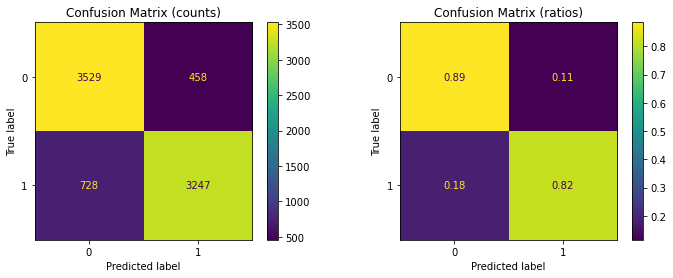

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_test, grid_cv.predict(X_test), display_labels=[0,1], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_test, grid_cv.predict(X_test), normalize="true", display_labels=[0,1], ax=ax2)

plt.show()